# Introduction
In this notebook we will be teaching you how to load the data for Image Classification, as well as teaching you how to run initial baseline models across the dataset. We will be utilizing the Pytorch Lightning package to conduct all of our experiments. Documentation for this can be found at: https://lightning.ai/docs/pytorch/stable/

# Required Packages 
Below, we list all the required packages for this project. If you're new to notebooks, you can execute the current cell by pressing "Shift-Enter". Notably, we will use:

* **Pil:** For transforming images.
* **Matplotlib:** For displaying data.
* **PyTorch and PyTorch Lightning:** For creating and managing models, and loading data.

In [1]:
import os
import json
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchmetrics import F1Score
from torchvision import transforms
import torchvision.models as models

import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

# Loading the Dataset

## Transforms
Before we can begin training, it's essential to ensure the data is properly loaded and preprocessed. We will start by defining a series of transformations to prepare our images:

* Resizing: Adjusting the image size to a consistent dimension (e.g., 256x256 pixels) reduces computational load and standardizes input size.
* Normalizing: This step scales pixel values to a standard range, typically 0 to 1, which facilitates model training by providing a consistent scale of input features.

These preprocessing steps are crucial for optimizing training speed and improving model performance, especially in computer vision tasks where the full quality of images is often unnecessary for effective learning.




In [2]:
# Define transformations for the train, validation, and test sets
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

## Defining Labels & Loading the Data
In this section, we define a custom class called CSUBuildingDataset, which is responsible for loading our image data for a computer vision task. This class utilizes JSON files to access metadata, including the annotations that associate each image with a label, which in this context is the name of a building.

Here's a breakdown of the CSUBuildingDataset class:

Method Definitions:
* **__len__:** Returns the total number of images in the dataset.
* **__getitem__:** Retrieves an image by index, applies any transformations, and returns the image along with its label index.

In [3]:
class CSUBuildingDataset(Dataset):
    def __init__(self, json_file, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.data = []
        self.labels = []

        # Load the json file
        with open(root_dir+'/'+json_file, 'r') as f:
            print(f"Loading data from {root_dir+'/'+json_file}")
            building_data = json.load(f)

        # Building names and their corresponding labels
        self.building_names = sorted(list(building_data.keys()))

        # Prepare the data and labels
        for building_name, images in building_data.items():
            for image_path in images:
                self.data.append(f"{image_path}")
                self.labels.append(self.building_names.index(building_name))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_name = self.data[idx]
        image = Image.open(img_name).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)
        else:
            image = transforms.ToTensor()(image)

        return image, label

## Defining Our Models
Now that we have created a class that will load our data, we will create our class that contains our machine learning model! We begin by defining a class and constructor called "BuildingClassifier", before creating a definition called "_get_model". In "_get_model", we have pre-defined 6 seperate models from PyTorch, such as: ResNet50, and Vit16. More documentation on these models can be found here: https://pytorch.org/vision/stable/models.html.

After we define our models, we create a "forward" definition, which will allow the training to progress, and three stepping functions: train, val, and test. Finally, we define an optimizer, which can be useful in training, and reducing things such as overfitting.

In [4]:
class BuildingClassifier(pl.LightningModule):
    def __init__(self, num_classes=48, learning_rate=0.001, model_name='resnet50'):
        super(BuildingClassifier, self).__init__()
        self.num_classes = num_classes
        self.learning_rate = learning_rate
        self.model_name = model_name
        self.model = self._get_model()
        self.criterion = torch.nn.CrossEntropyLoss()
        self.f1_score = F1Score(task='multiclass', num_classes=num_classes, average='macro')
    
    def _get_model(self):
        print('Current model:', self.model_name)
        if self.model_name == 'resnet50':
            m = models.resnet50(pretrained=True)
            in_features = m.fc.in_features
            m.fc = torch.nn.Linear(in_features, self.num_classes)
            return m
        elif self.model_name == 'resnext50':
            m = models.resnext50_32x4d(pretrained=True)
            in_features = m.fc.in_features
            m.fc = torch.nn.Linear(in_features, self.num_classes)
            return m
        elif self.model_name == 'vgg-19':
            m = models.vgg19(pretrained=True)
            in_features = m.classifier[6].in_features
            m.classifier[6] = torch.nn.Linear(in_features, self.num_classes)
            return m
        elif self.model_name == 'vit':
            m = models.vit_l_16(pretrained=True)
            in_features = m.heads.head.in_features
            m.heads.head = torch.nn.Linear(in_features, self.num_classes)
            return m
        elif self.model_name == 'swin_s':
            m = models.swin_v2_s(pretrained=True)
            in_features = m.head.in_features
            m.head = torch.nn.Linear(in_features, self.num_classes)
            return m
        elif self.model_name == 'efficientnet':
            m = models.efficientnet_v2_m(pretrained=True)
            in_features = m.classifier[1].in_features
            m.classifier[1] = torch.nn.Linear(in_features, self.num_classes)
            return m
        else:
            raise ValueError(f"Model {self.model_name} not supported")

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)
        loss = self.criterion(outputs, labels)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)
        loss = self.criterion(outputs, labels)
        _, predicted = torch.max(outputs, 1)
        acc = (predicted == labels).sum().item() / labels.size(0)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)

    def test_step(self, batch, batch_idx):
        inputs, labels = batch
        outputs = self(inputs)
        loss = self.criterion(outputs, labels)
        _, predicted = torch.max(outputs, 1)
        acc = (predicted == labels).sum().item() / labels.size(0)
        f1 = self.f1_score(predicted, labels)
        self.log('test_loss', loss, prog_bar=True)
        self.log('test_acc', acc, prog_bar=True)
        self.log('test_f1', f1, prog_bar=True)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

## We can now tie everything together, load the data, and define our model!

###  Transformations
* **Preprocessing Steps:** The script applies several transformations to prepare images for neural network processing. These include:
* **Resize:** Adjusts images to a uniform size (256 pixels).
* **ToTensor:** Converts images to PyTorch tensors.
* **Normalize:** Scales image pixel values using means and standard deviations of ImageNet, aligning with common model expectations.

### Dataset and DataLoaders
* **Dataset Loading:** Loads training, validation, and testing datasets from specified JSON files, which contain paths to images and their corresponding labels.
* **DataLoaders:** Configured to handle data in batches of 32, enhancing computational efficiency. Utilizes 16 worker threads for parallel data loading.
Training DataLoader shuffles data to ensure model generalization, while validation and test loaders process data sequentially.

### Model Configuration
* **Model Selection:** Offers a choice among several pre-defined models (e.g., ResNet50, Inception V3). The chosen model for this setup is resnet50.
* **BuildingClassifier Class:** Custom class that extends pl.LightningModule, handling tasks such as forward passes, training steps, and validation/testing evaluations.

### Training Setup
* **ModelCheckpoint:** Saves the model with the lowest validation loss, ensuring retention of the best-performing version.
* **EarlyStopping:** Prevents overfitting by halting training if validation loss does not improve for five consecutive epochs.

### Trainer Configuration:
Set to train for up to 100 epochs with GPU acceleration, if available. Incorporates callbacks to monitor and optimize training process efficiency and effectiveness.

### Execution
The Trainer object orchestrates the training, validation, and testing phases, utilizing the configurations specified for the BuildingClassifier model and the data provided through the DataLoaders.

In [5]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

train_dataset = CSUBuildingDataset(json_file='train.json', root_dir='/data/CCVC/neurips_2024/classification', transform=transform)
val_dataset = CSUBuildingDataset(json_file='val.json', root_dir='/data/CCVC/neurips_2024/classification', transform=transform)
test_dataset = CSUBuildingDataset(json_file='test.json', root_dir='/data/CCVC/neurips_2024/classification', transform=transform)

batch_size = 32
n_workers = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=n_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=n_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=n_workers)

model_names = ['resnet50', 'resnext50', 'vgg-19', 'vit', 'swin_s', 'efficientnet']
model_name = model_names[0]

model = BuildingClassifier(num_classes=48, learning_rate=0.0001, model_name=model_name)

checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    dirpath='checkpoints',
    filename='best-checkpoint',
    save_top_k=1,
    mode='min'
)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5)
n_gpu = torch.cuda.device_count()

trainer = Trainer(
    max_epochs=100,
    accelerator="gpu",
    devices=n_gpu if n_gpu > 0 else None,
    callbacks=[checkpoint_callback, early_stopping_callback]
)

Loading data from /data/CCVC/neurips_2024/classification/train.json
Loading data from /data/CCVC/neurips_2024/classification/val.json
Loading data from /data/CCVC/neurips_2024/classification/test.json
Current model: resnet50


/home/cjung/.conda/envs/csu/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/cjung/.conda/envs/csu/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/cjung/.conda/envs/csu/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as

## Verify Dataloading
An important step when working in Computer Vision is double checking your data. Below, the method "showImages", will display 5 images that we have loaded randomly. You can run the cell multiple times, to see a variety of the dataset. Note these images will be what the model sees, so they may look different than the original data. We recommend looking at images from all the data splits, train, test, and val.

In [6]:
def show_images(dataset, num_images=5):
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))
    indices = np.random.choice(len(dataset), num_images, replace=False)

    for i, ax in enumerate(axes):
        image, label = dataset[indices[i]]

        # Reverse the normalization process
        mean=[0.485, 0.456, 0.406]
        std=[0.229, 0.224, 0.225]
        mean = torch.tensor(mean).view(3, 1, 1)
        std = torch.tensor(std).view(3, 1, 1)
        image = image * std + mean
        image = image.permute(1, 2, 0).numpy()
        
        ax.imshow(image)
        ax.set_title(dataset.building_names[label])
        ax.axis('off')

    plt.show()

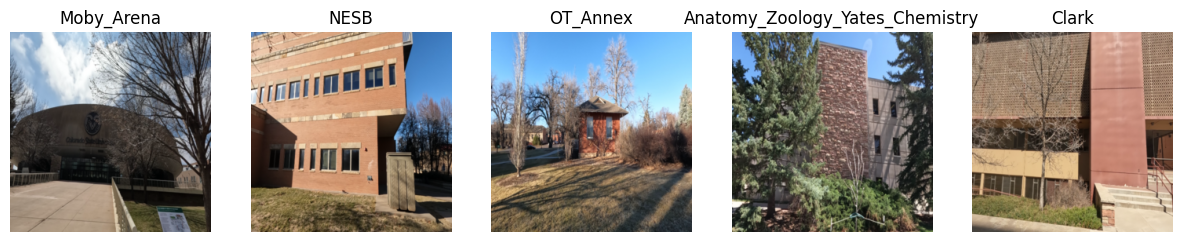

In [7]:
show_images(train_dataset)
#show_images(val_dataset)
# show_images(test_dataset)

## Utilizing the Pytorch Trainer Method
Understanding trainer.fit(model, train_loader, val_loader) in PyTorch Lightning

* **trainer.fit()** automates the training process for your machine learning model. Here’s what each component is for:

* **model:** This is your neural network, defined in a class that handles computations like forward passes and backpropagation.

* **train_loader:** A DataLoader that provides batches of training data. It shuffles the data to help the model generalize better.

* **val_loader:** Similar to train_loader but for validation data, used to evaluate the model’s performance on unseen data after each training epoch to monitor for overfitting.




In [8]:
trainer.fit(model, train_loader, val_loader)

You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/2
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/2
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. 

Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  5.84it/s]

/home/cjung/.conda/envs/csu/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:441: It is recommended to use `self.log('val_loss', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
/home/cjung/.conda/envs/csu/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:441: It is recommended to use `self.log('val_acc', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.


/home/cjung/.conda/envs/csu/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:298: The number of training batches (36) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 23: 100%|██████████| 36/36 [00:06<00:00,  5.88it/s, v_num=168, val_loss=0.136, val_acc=0.973]


## Testing our Model
Similar to how we trained our model with the PyTorch Lightning Trainer, we can utilize the trainer method to test our model.

In [9]:
trainer.test(model, test_loader)

You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/2


You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/2
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 2 processes
----------------------------------------------------------------------------------------------------

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 1 - CUDA_VISIBLE_DEVICES: [0,1]
/home/cjung/.conda/envs/csu/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:232: Using `DistributedSampler` with the dataloaders. During `trainer.test()`, it is recom

Testing DataLoader 0: 100%|██████████| 12/12 [00:06<00:00,  1.82it/s]

/home/cjung/.conda/envs/csu/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:441: It is recommended to use `self.log('test_loss', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
/home/cjung/.conda/envs/csu/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:441: It is recommended to use `self.log('test_acc', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
/home/cjung/.conda/envs/csu/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:441: It is recommended to use `self.log('test_f1', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.


Testing DataLoader 0: 100%|██████████| 12/12 [00:06<00:00,  1.81it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9917582273483276
         test_f1            0.9539879560470581
        test_loss           0.07185593247413635
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.07185593247413635,
  'test_acc': 0.9917582273483276,
  'test_f1': 0.9539879560470581}]

## Displaying Predictions!
After testing, similar to how we verified our data, we may display images that our model has classified. We often want to display mis-classifications, to see where our model is performing poorly, before making changes to address these issues.

## Saving Our Model
In case of failure, or model deployment we often want to save our best model. The line of code below will save the "weights" of the model, which we can reuse in the future.

In [10]:
torch.save(model.state_dict(), f'/data/CCVC/neurips_2024/classification/weights/{model_name}.pth')

## Running All models

In [ ]:
model_names = ['vgg-19', 'resnet50', 'resnext50', 'vit', 'swin_s', 'efficientnet']

for model_name in model_names:
    img_size = 224
    if model_name == 'inception_v3':
        img_size = 299
    if model_name == 'vit':
        img_size = 224
    transform = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])

    train_dataset = CSUBuildingDataset(json_file='train.json', root_dir='/data/CCVC/neurips_2024/classification', transform=transform)
    val_dataset = CSUBuildingDataset(json_file='val.json', root_dir='/data/CCVC/neurips_2024/classification', transform=transform)
    test_dataset = CSUBuildingDataset(json_file='test.json', root_dir='/data/CCVC/neurips_2024/classification', transform=transform)

    batch_size = 8
    n_workers = 4
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=n_workers)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=n_workers)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=n_workers)

    model = BuildingClassifier(num_classes=48, learning_rate=0.0001, model_name=model_name)

    checkpoint_callback = ModelCheckpoint(
        monitor='val_loss',
        dirpath='checkpoints',
        filename='best-checkpoint',
        save_top_k=1,
        mode='min'
    )
    early_stopping_callback = EarlyStopping(monitor='val_loss', patience=10)
    n_gpu = torch.cuda.device_count()

    trainer = Trainer(
        max_epochs=100,
        accelerator="gpu",
        devices=n_gpu if n_gpu > 0 else None,
        callbacks=[checkpoint_callback, early_stopping_callback]
    )
    trainer.fit(model, train_loader, val_loader)
    trainer.test(model, test_loader)
    torch.save(model.state_dict(), f"{model_name}.pth")

Loading data from /data/CCVC/neurips_2024/classification/train.json
Loading data from /data/CCVC/neurips_2024/classification/val.json
Loading data from /data/CCVC/neurips_2024/classification/test.json
Current model: vgg-19


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/2
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/2
------------

Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  6.52it/s]

/home/cjung/.conda/envs/csu/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:441: It is recommended to use `self.log('val_loss', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
/home/cjung/.conda/envs/csu/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:441: It is recommended to use `self.log('val_acc', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.


Epoch 0:  99%|█████████▉| 142/143 [00:18<00:00,  7.77it/s, v_num=82]       

/home/cjung/.conda/envs/csu/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608847532/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
/home/cjung/.conda/envs/csu/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608847532/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,


Epoch 24: 100%|██████████| 143/143 [00:20<00:00,  7.12it/s, v_num=82, val_loss=0.462, val_acc=0.885]


You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/2
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/2
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. 

Testing DataLoader 0: 100%|██████████| 46/46 [00:01<00:00, 36.38it/s]

/home/cjung/.conda/envs/csu/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:441: It is recommended to use `self.log('test_loss', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
/home/cjung/.conda/envs/csu/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:441: It is recommended to use `self.log('test_acc', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
/home/cjung/.conda/envs/csu/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:441: It is recommended to use `self.log('test_f1', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.


Testing DataLoader 0: 100%|██████████| 46/46 [00:01<00:00, 36.22it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8983516693115234
         test_f1            0.7724506258964539
        test_loss           0.3987100124359131
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Loading data from /data/CCVC/neurips_2024/classification/train.json
Loading data from /data/CCVC/neurips_2024/classification/val.json
Loading data from /data/CCVC/neurips_2024/classification/test.json
Current model: resnet50


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/2
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/2
------------

Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  5.56it/s]

/home/cjung/.conda/envs/csu/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:441: It is recommended to use `self.log('val_loss', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
/home/cjung/.conda/envs/csu/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:441: It is recommended to use `self.log('val_acc', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.


Epoch 0:  99%|█████████▉| 142/143 [00:06<00:00, 22.59it/s, v_num=84]       

/home/cjung/.conda/envs/csu/lib/python3.12/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608847532/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 0: 100%|██████████| 143/143 [00:06<00:00, 22.26it/s, v_num=84]

/home/cjung/.conda/envs/csu/lib/python3.12/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608847532/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 16: 100%|██████████| 143/143 [00:08<00:00, 17.31it/s, v_num=84, val_loss=0.195, val_acc=0.945]


You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/2
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/2
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. 

Testing DataLoader 0: 100%|██████████| 46/46 [00:01<00:00, 45.14it/s]

/home/cjung/.conda/envs/csu/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:441: It is recommended to use `self.log('test_loss', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
/home/cjung/.conda/envs/csu/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:441: It is recommended to use `self.log('test_acc', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
/home/cjung/.conda/envs/csu/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:441: It is recommended to use `self.log('test_f1', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.


Testing DataLoader 0: 100%|██████████| 46/46 [00:01<00:00, 44.90it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9670329689979553
         test_f1            0.9195469617843628
        test_loss           0.14457330107688904
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Loading data from /data/CCVC/neurips_2024/classification/train.json
Loading data from /data/CCVC/neurips_2024/classification/val.json
Loading data from /data/CCVC/neurips_2024/classification/test.json
Current model: resnext50


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/2
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/2
------------

Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  5.32it/s]

/home/cjung/.conda/envs/csu/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:441: It is recommended to use `self.log('val_loss', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
/home/cjung/.conda/envs/csu/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:441: It is recommended to use `self.log('val_acc', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.


Epoch 0:   0%|          | 0/143 [00:00<?, ?it/s]                           

/home/cjung/.conda/envs/csu/lib/python3.12/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608847532/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/home/cjung/.conda/envs/csu/lib/python3.12/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at /opt/conda/conda-bld/pytorch_1712608847532/work/aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 13: 100%|██████████| 143/143 [00:09<00:00, 15.31it/s, v_num=86, val_loss=0.170, val_acc=0.953]


You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/2
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/2
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. 

Testing DataLoader 0: 100%|██████████| 46/46 [00:01<00:00, 41.66it/s]

/home/cjung/.conda/envs/csu/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:441: It is recommended to use `self.log('test_loss', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
/home/cjung/.conda/envs/csu/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:441: It is recommended to use `self.log('test_acc', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
/home/cjung/.conda/envs/csu/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:441: It is recommended to use `self.log('test_f1', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.


Testing DataLoader 0: 100%|██████████| 46/46 [00:01<00:00, 41.46it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9862637519836426
         test_f1            0.9489536285400391
        test_loss           0.06453938782215118
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Loading data from /data/CCVC/neurips_2024/classification/train.json
Loading data from /data/CCVC/neurips_2024/classification/val.json
Loading data from /data/CCVC/neurips_2024/classification/test.json
Current model: vit


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/2
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/2
------------

Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  6.04it/s]

/home/cjung/.conda/envs/csu/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:441: It is recommended to use `self.log('val_loss', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
/home/cjung/.conda/envs/csu/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:441: It is recommended to use `self.log('val_acc', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.


Epoch 22: 100%|██████████| 143/143 [01:00<00:00,  2.37it/s, v_num=88, val_loss=0.101, val_acc=0.973] 


You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/2
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/2
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. 

Testing DataLoader 0: 100%|██████████| 46/46 [00:03<00:00, 12.67it/s]

/home/cjung/.conda/envs/csu/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:441: It is recommended to use `self.log('test_loss', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
/home/cjung/.conda/envs/csu/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:441: It is recommended to use `self.log('test_acc', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
/home/cjung/.conda/envs/csu/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:441: It is recommended to use `self.log('test_f1', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.


Testing DataLoader 0: 100%|██████████| 46/46 [00:03<00:00, 12.65it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9835164546966553
         test_f1            0.9443455934524536
        test_loss           0.05154144763946533
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Loading data from /data/CCVC/neurips_2024/classification/train.json
Loading data from /data/CCVC/neurips_2024/classification/val.json
Loading data from /data/CCVC/neurips_2024/classification/test.json
Current model: swin_s


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/2
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/2
------------

Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  4.55it/s]

/home/cjung/.conda/envs/csu/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:441: It is recommended to use `self.log('val_loss', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
/home/cjung/.conda/envs/csu/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:441: It is recommended to use `self.log('val_acc', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.


Epoch 13: 100%|██████████| 143/143 [00:22<00:00,  6.49it/s, v_num=90, val_loss=0.231, val_acc=0.929]


You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/2
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/2
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. 

Testing DataLoader 0: 100%|██████████| 46/46 [00:01<00:00, 27.90it/s]

/home/cjung/.conda/envs/csu/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:441: It is recommended to use `self.log('test_loss', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
/home/cjung/.conda/envs/csu/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:441: It is recommended to use `self.log('test_acc', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
/home/cjung/.conda/envs/csu/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:441: It is recommended to use `self.log('test_f1', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.


Testing DataLoader 0: 100%|██████████| 46/46 [00:01<00:00, 27.81it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9642857313156128
         test_f1             0.895916223526001
        test_loss           0.10048621147871017
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Loading data from /data/CCVC/neurips_2024/classification/train.json
Loading data from /data/CCVC/neurips_2024/classification/val.json
Loading data from /data/CCVC/neurips_2024/classification/test.json
Current model: efficientnet


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/2
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/2
------------

Sanity Checking DataLoader 0: 100%|██████████| 2/2 [00:00<00:00,  4.97it/s]

/home/cjung/.conda/envs/csu/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:441: It is recommended to use `self.log('val_loss', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
/home/cjung/.conda/envs/csu/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:441: It is recommended to use `self.log('val_acc', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.


Epoch 23: 100%|██████████| 143/143 [00:21<00:00,  6.80it/s, v_num=92, val_loss=0.293, val_acc=0.934]


You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/2
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/2
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. 

Testing DataLoader 0: 100%|██████████| 46/46 [00:01<00:00, 30.48it/s]

/home/cjung/.conda/envs/csu/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:441: It is recommended to use `self.log('test_loss', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
/home/cjung/.conda/envs/csu/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:441: It is recommended to use `self.log('test_acc', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
/home/cjung/.conda/envs/csu/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:441: It is recommended to use `self.log('test_f1', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.


Testing DataLoader 0: 100%|██████████| 46/46 [00:01<00:00, 30.37it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9395604133605957
         test_f1            0.8602139949798584
        test_loss           0.2471240758895874
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
